In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
import numpy as np
import pandas as pd
import random
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import Model
from keras.utils import np_utils

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
import itertools 

import tensorflow as tf

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
token = '{"username":"andreasadityasumasta","key":"772afdf9ee383c04a5a7ae75b8d5e1c8"}'

with open("kaggle.json", "w") as f:
  f.write(token)
  f.close()

In [ ]:
! pip install -q kaggle

In [ ]:
# mkdir artinya buat folder baru -> namanya .kaggle
! mkdir ~/.kaggle
# cp artinya copy -> file kaggle.json ke folder .kaggle
! cp kaggle.json ~/.kaggle/
# chmod membuat agar file dapat diakses oleh colab
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d drscarlat/melanoma

melanoma.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip melanoma.zip

Archive:  melanoma.zip
replace DermMel/test/Melanoma/AUG_0_1001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
train_dir = os.path.join("DermMel", "train_sep")
test_dir = os.path.join("DermMel", "test")
val_dir = os.path.join("DermMel", "valid")
#Data Augmentation SEGMENT
#Define our data directory

#initialize data-augmentation
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

#Flow training and testing
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = "categorical"
)
val_generator = val_data_generator.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = "categorical"
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = "categorical"
)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [ ]:
#Download Inception Weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

N
--2021-05-30 14:14:05--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  66.1MB/s    in 1.3s    

2021-05-30 14:14:06 (66.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

In [ ]:

local_weight_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create an instance of the inception model from the local pre-trained weights
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weight_file)

# Make all the layers in the pre-trained model non-trainable

for layer in pre_trained_model.layers[:-5]:
  layer.trainable = False
for layer in pre_trained_model.layers[-5:]:
  layer.trainable = True

In [ ]:
# Output Layer
last_layer = pre_trained_model.get_layer('mixed7')
print("Last layer output shape : {}".format(last_layer.output_shape))
last_output = last_layer.output

Last layer output shape : (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import Adam

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='swish')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='swish')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='swish')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2, activation="softmax")(x)

                    
model = Model(pre_trained_model.input, x)


for layer in model.layers[:-8]:
  layer.trainable = False
for layer in model.layers[-8:]:
  layer.trainable = True


model.compile(optimizer = Adam(),
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

In [ ]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
    steps_per_epoch=50
)

Epoch 1/10
50/50 [==============================] - 31s 574ms/step - loss: 0.5205 - accuracy: 0.7410 - val_loss: 0.4366 - val_accuracy: 0.7937
Epoch 2/10
50/50 [==============================] - 27s 548ms/step - loss: 0.4655 - accuracy: 0.7860 - val_loss: 0.4072 - val_accuracy: 0.8099
Epoch 3/10
50/50 [==============================] - 27s 550ms/step - loss: 0.4320 - accuracy: 0.8090 - val_loss: 0.3798 - val_accuracy: 0.8358
Epoch 4/10
50/50 [==============================] - 27s 549ms/step - loss: 0.4340 - accuracy: 0.7890 - val_loss: 0.3904 - val_accuracy: 0.8310
Epoch 5/10
50/50 [==============================] - 27s 550ms/step - loss: 0.3922 - accuracy: 0.8230 - val_loss: 0.3480 - val_accuracy: 0.8484
Epoch 6/10
50/50 [==============================] - 27s 548ms/step - loss: 0.3912 - accuracy: 0.8330 - val_loss: 0.3602 - val_accuracy: 0.8405
Epoch 7/10
50/50 [==============================] - 27s 543ms/step - loss: 0.4094 - accuracy: 0.8100 - val_loss: 0.3371 - val_accuracy: 0.8599

In [ ]:
#history = model.fit(
#    train_generator,
#    validation_data = val_generator,
#    epochs = 100,
#    steps_per_epoch=20
#)  

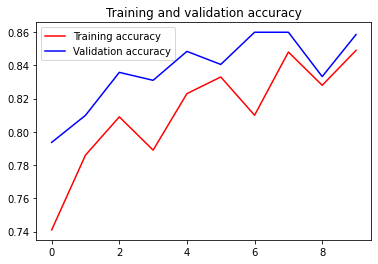

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 


#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)


# print(target_names)
#Confution Matrix


Y_pred = model.predict_generator(test_generator)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

    Melanoma       0.51      0.47      0.49      1781
 NotMelanoma       0.51      0.55      0.53      1780

    accuracy                           0.51      3561
   macro avg       0.51      0.51      0.51      3561
weighted avg       0.51      0.51      0.51      3561



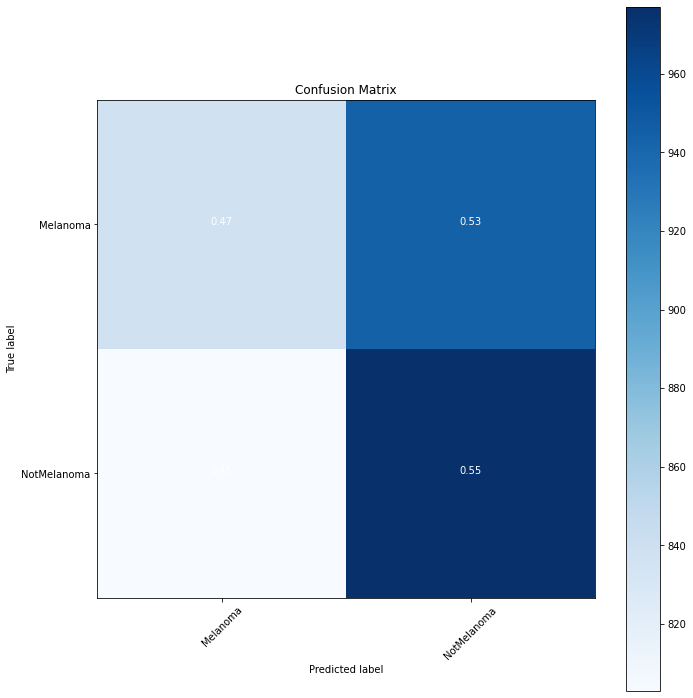

In [ ]:
import numpy as np
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [ ]:
import shutil
shutil.make_archive('model', 'zip', 'model')

'/content/model.zip'

In [ ]:
print(cm)

[[837 944]
 [803 977]]
